# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
# Import essential libraries for data manipulation and analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')
df.head()


market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [3]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])



##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [4]:
# Convert categorical features to category type
categorical_cols = ['store_primary_category', 'order_protocol']
for col in categorical_cols:
    df[col] = df[col].astype('category')



#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [6]:
# Calculate time taken in minutes
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [7]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_day'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_day'].apply(lambda x: 1 if x >= 5 else 0).astype('category')


In [8]:
# Drop unnecessary columns
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [9]:
# Define target variable (y) and features (X)

X = df.drop(columns=['time_taken'])
X = pd.get_dummies(X, drop_first=True)
y = df['time_taken']

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [11]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

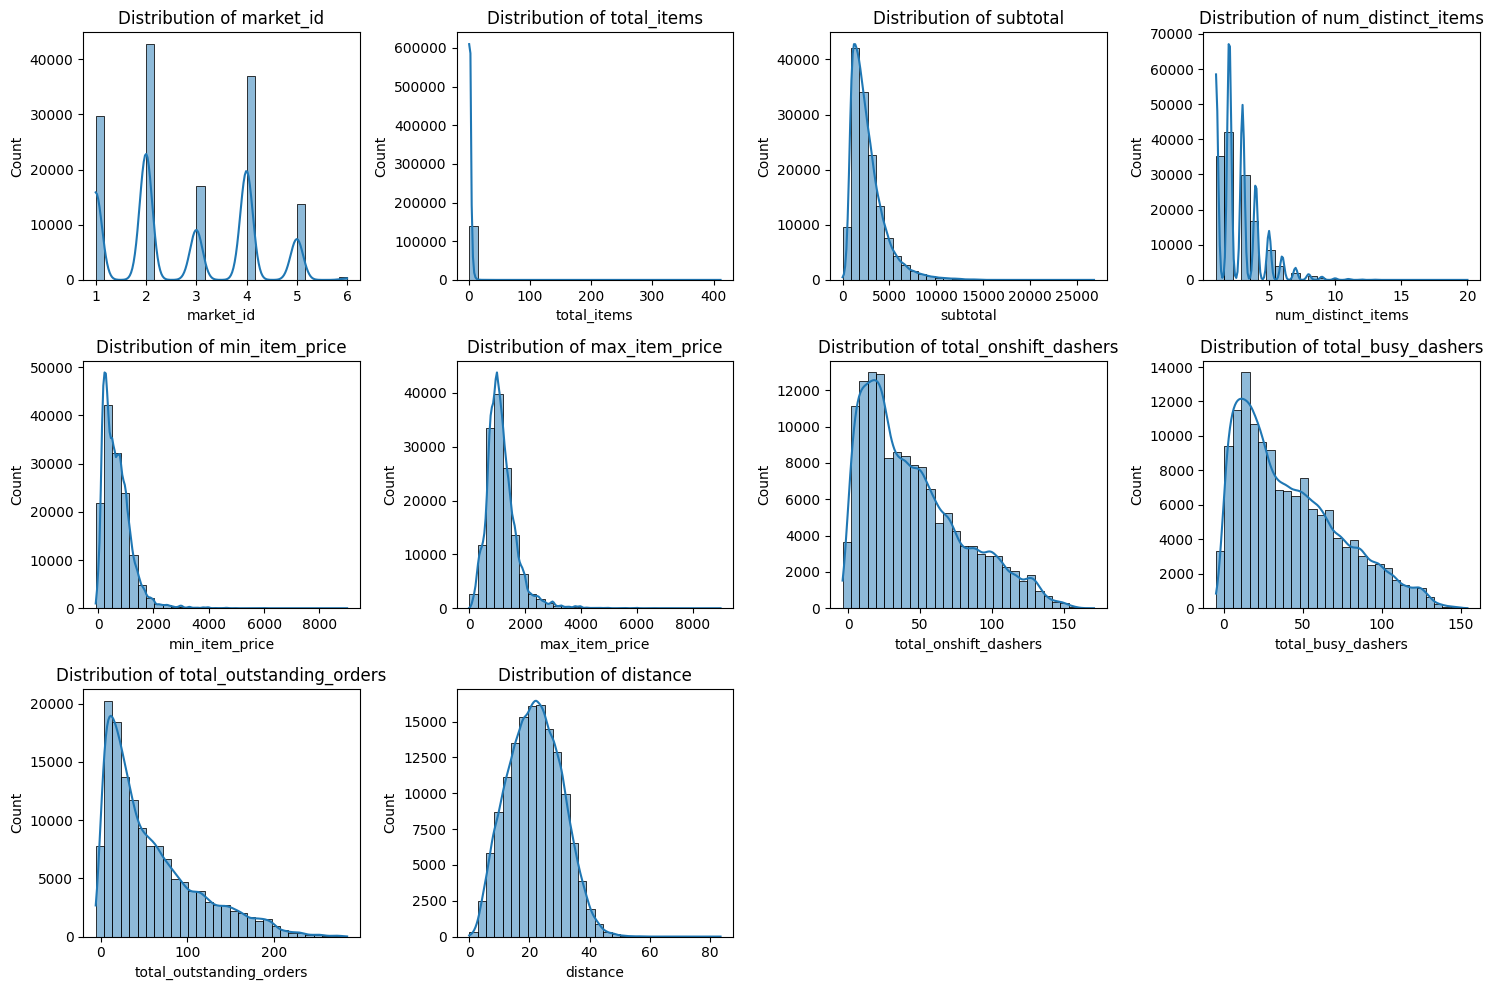

In [12]:
# Plot distributions for all numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i + 1)
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

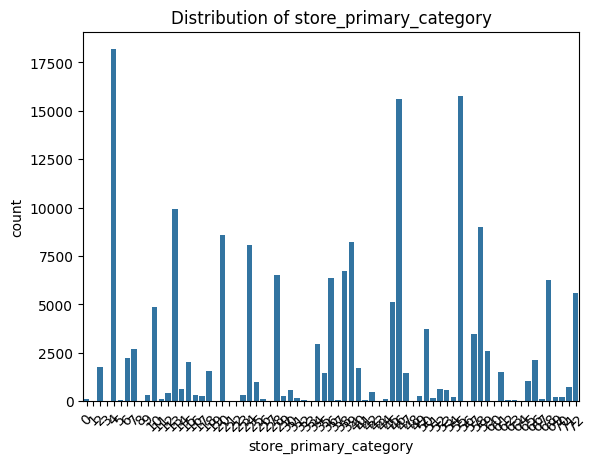

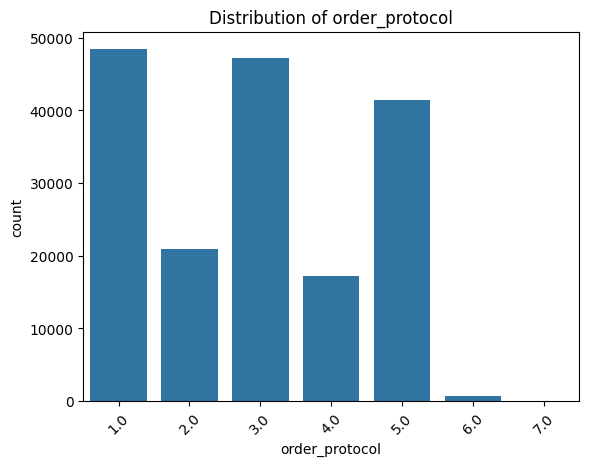

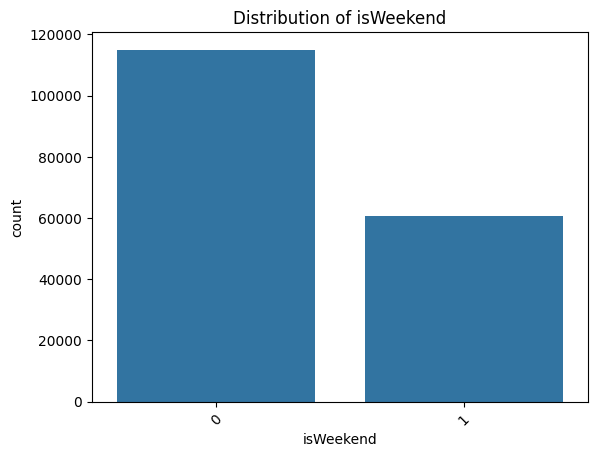

In [13]:
# Distribution of categorical columns

categorical_cols = df.select_dtypes(include='category').columns

for col in categorical_cols:
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

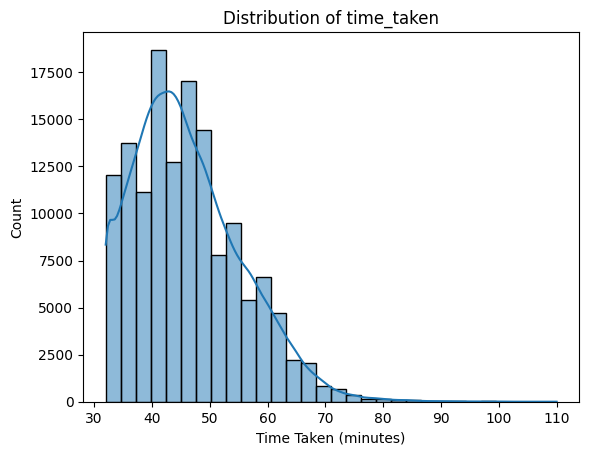

In [14]:
# Distribution of time_taken
sns.histplot(y_train, kde=True, bins=30)
plt.title('Distribution of time_taken')
plt.xlabel('Time Taken (minutes)')
plt.show()



#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

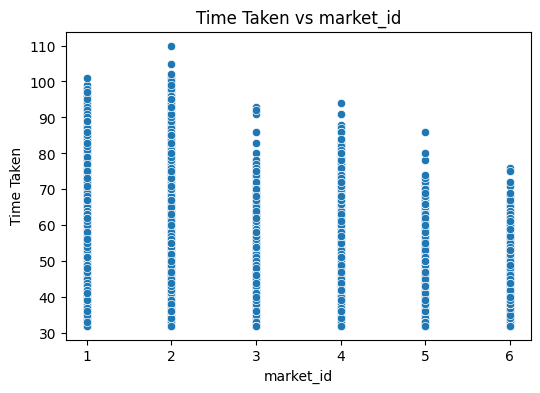

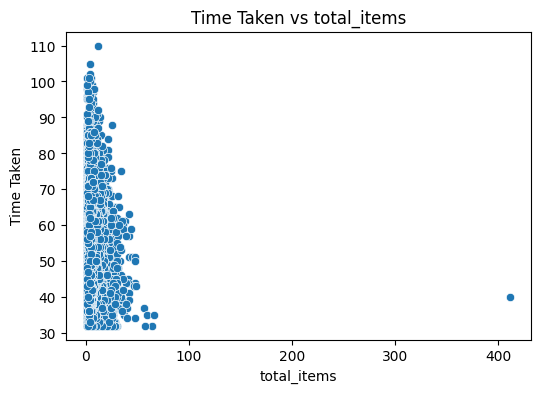

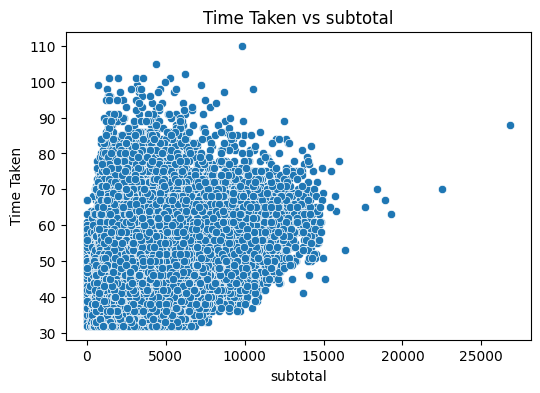

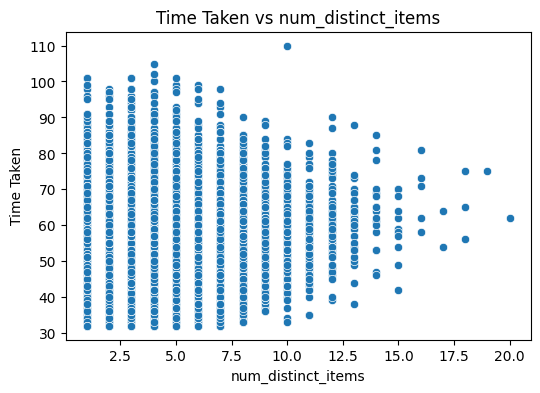

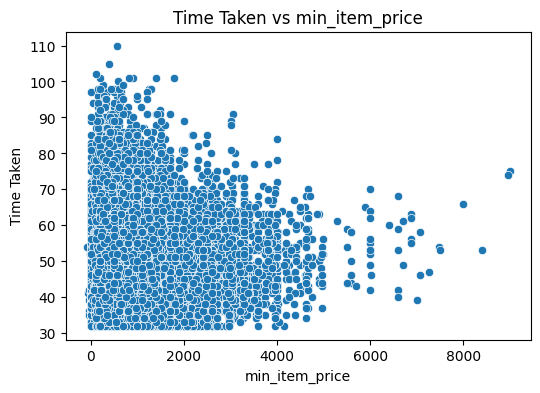

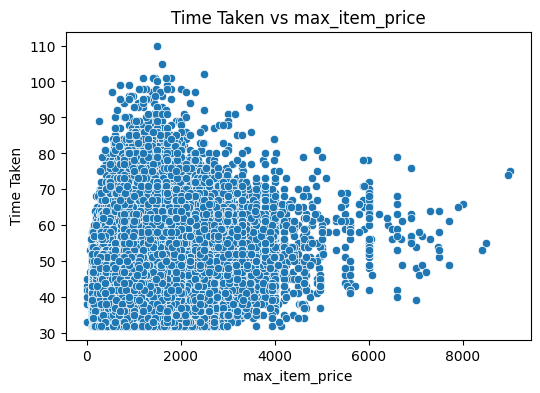

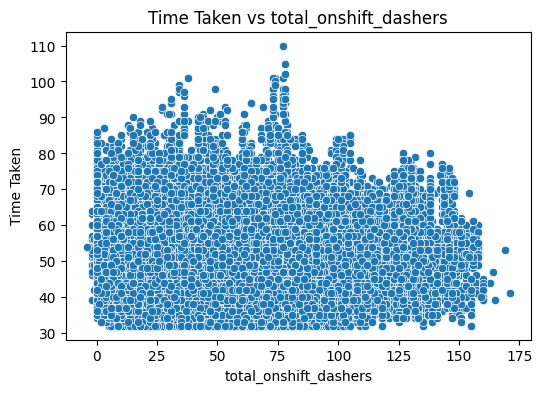

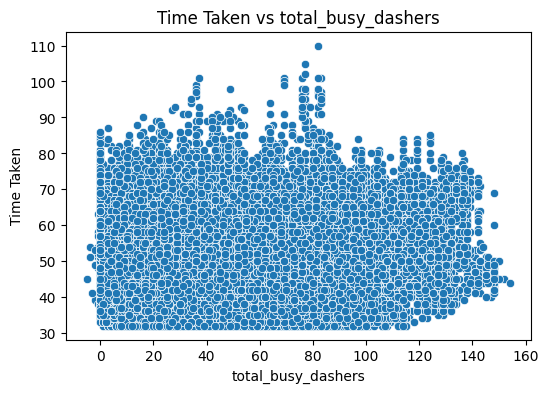

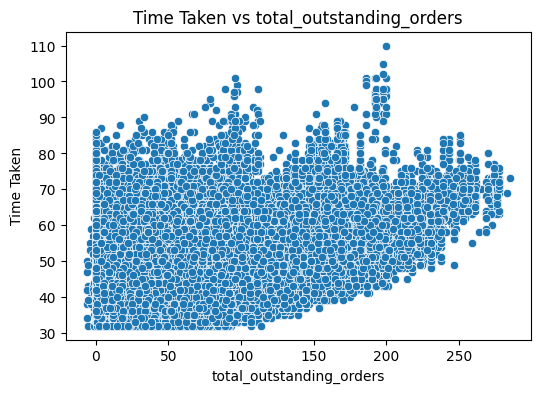

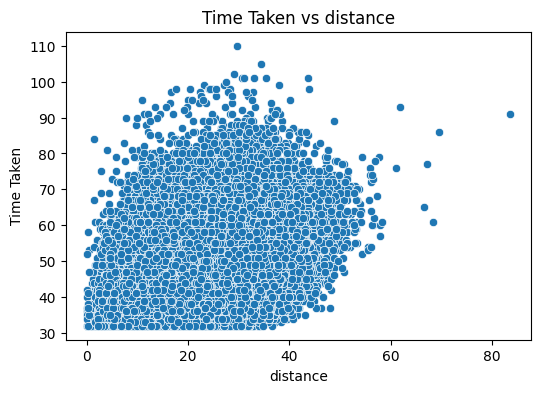

In [15]:
# Scatter plot to visualise the relationship between time_taken and other features
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train[col], y=y_train)
    plt.title(f'Time Taken vs {col}')
    plt.xlabel(col)
    plt.ylabel('Time Taken')
    plt.show()



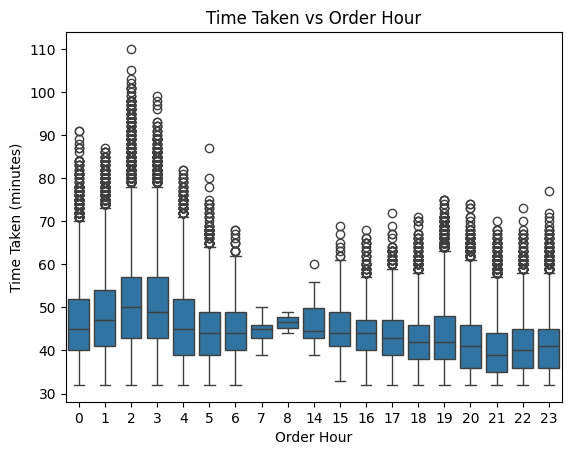

In [16]:
# Show the distribution of time_taken for different hours
sns.boxplot(x=df['order_hour'], y=df['time_taken'])
plt.title('Time Taken vs Order Hour')
plt.xlabel('Order Hour')
plt.ylabel('Time Taken (minutes)')
plt.show()



#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

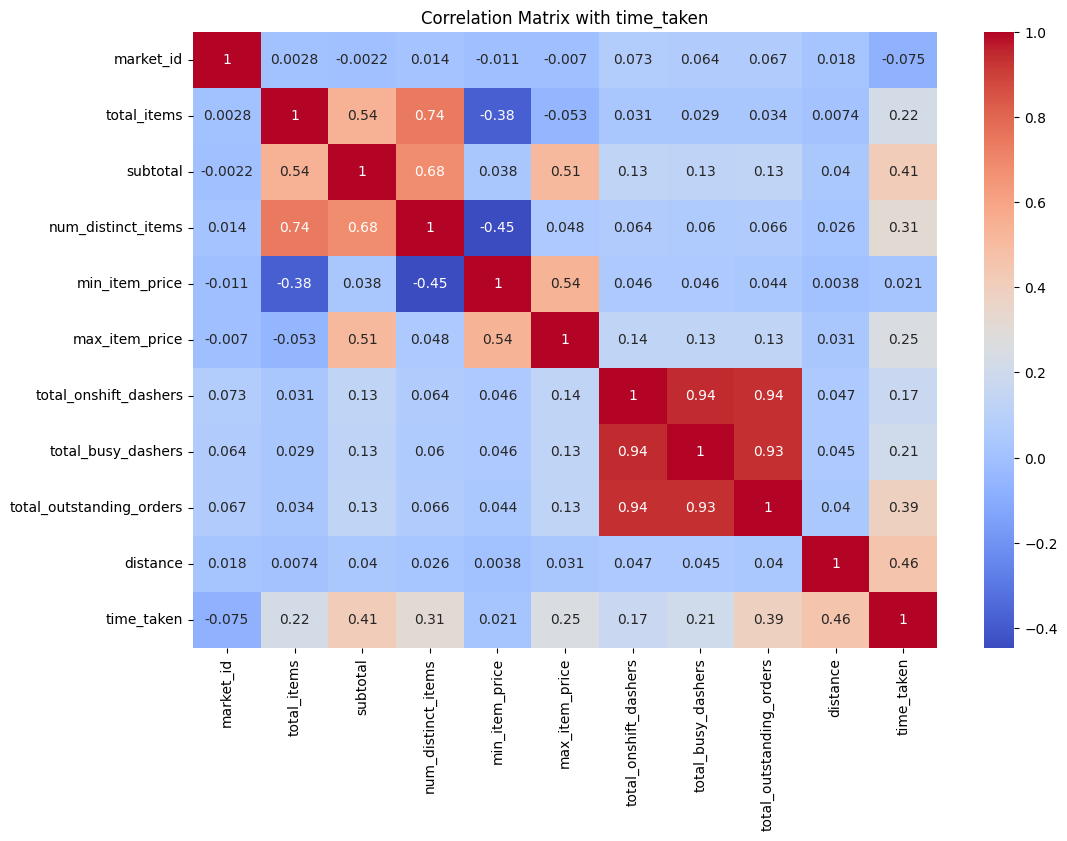

In [17]:
# Plot the heatmap of the correlation matrix

corr_matrix = pd.concat([X_train[numerical_cols], y_train], axis=1).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with time_taken')
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [18]:
# Drop 3-5 weakly correlated columns from training dataset

correlations = corr_matrix['time_taken'].drop('time_taken')
low_corr = correlations[correlations.abs() < 0.05].index.tolist()
print("Dropping weakly correlated features:", low_corr)

X_train.drop(columns=low_corr, inplace=True)
X_test.drop(columns=low_corr, inplace=True)


Dropping weakly correlated features: ['min_item_price']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

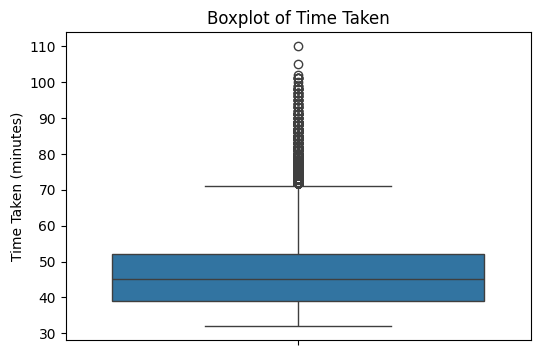

In [19]:
# Boxplot for time_taken
plt.figure(figsize=(6, 4))
sns.boxplot(y=y_train)
plt.title('Boxplot of Time Taken')
plt.ylabel('Time Taken (minutes)')
plt.show()



##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [20]:
# Handle outliers
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Keep only non-outliers
train_filter = (y_train >= lower_bound) & (y_train <= upper_bound)
X_train = X_train[train_filter]
y_train = y_train[train_filter]



## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [21]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols_test = X_test.select_dtypes(include=['int64', 'float64']).columns


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

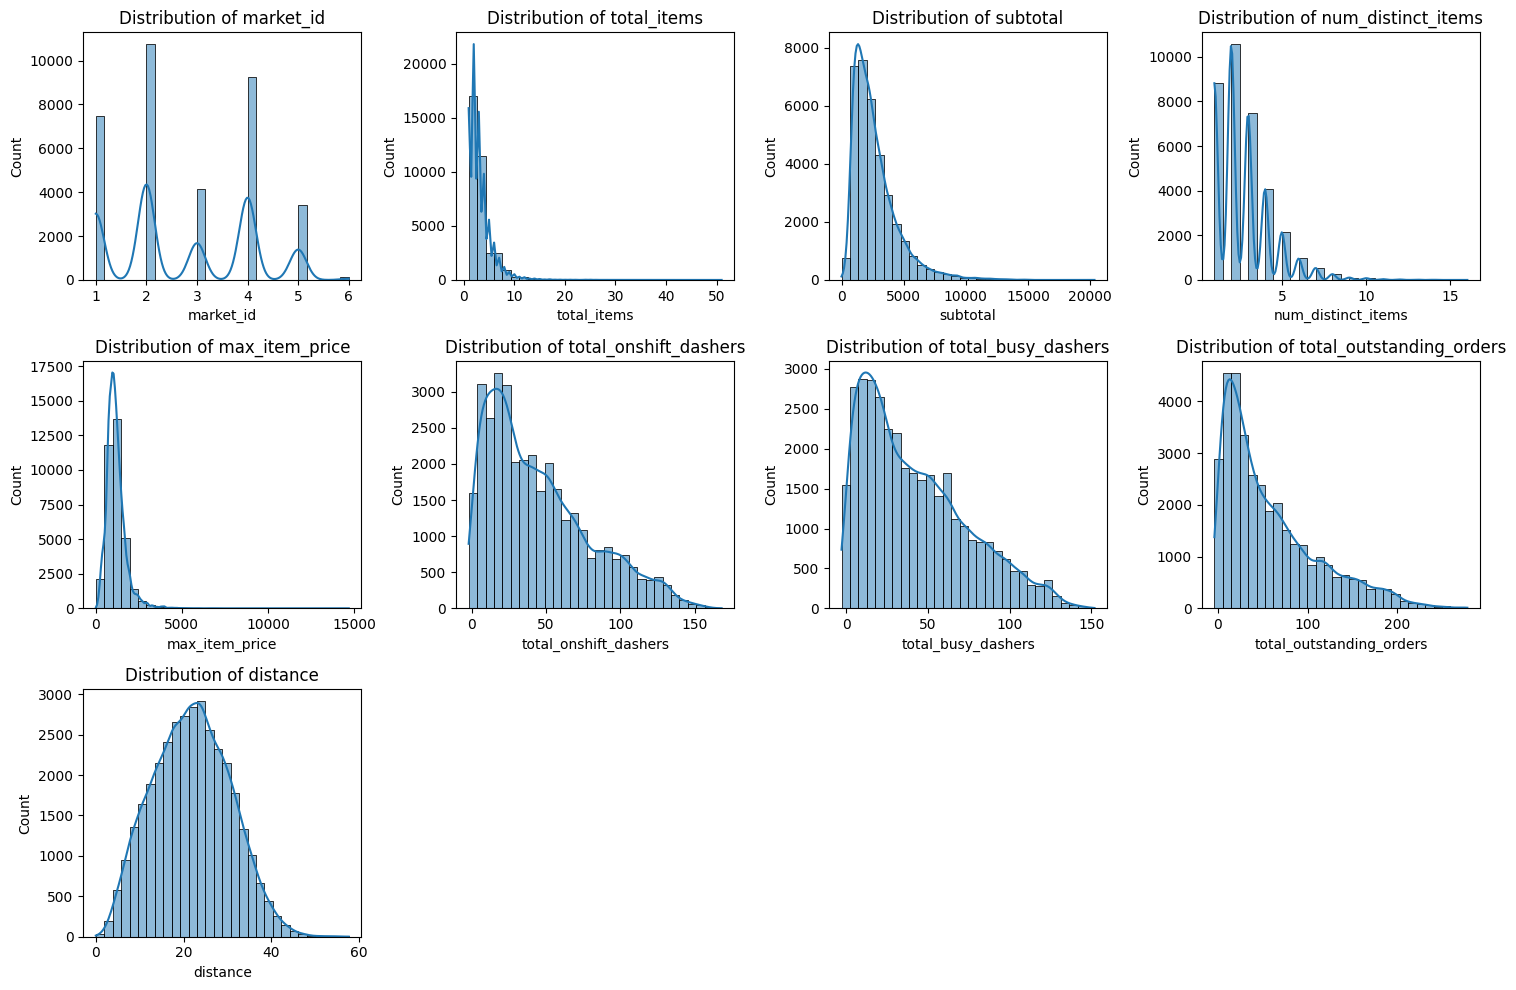

In [22]:
# Plot distributions for all numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_test):
    plt.subplot(3, 4, i + 1)
    sns.histplot(X_test[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


##### **4.1.2**
Check the distribution of categorical features

In [23]:
# Distribution of categorical columns

categorical_dummies = [col for col in X_test.columns if X_test[col].nunique() == 2 and X_test[col].dtype in [np.int64, np.uint8]]

for col in categorical_dummies:
    sns.countplot(x=X_test[col])
    plt.title(f'Distribution of dummy feature: {col}')
    plt.show()


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

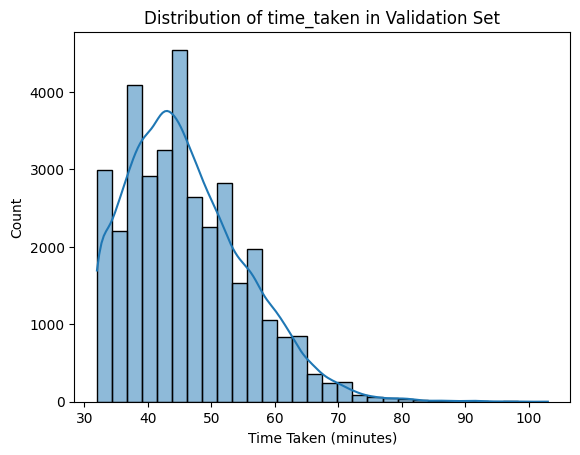

In [24]:
# Distribution of time_taken

sns.histplot(y_test, kde=True, bins=30)
plt.title('Distribution of time_taken in Validation Set')
plt.xlabel('Time Taken (minutes)')
plt.show()


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

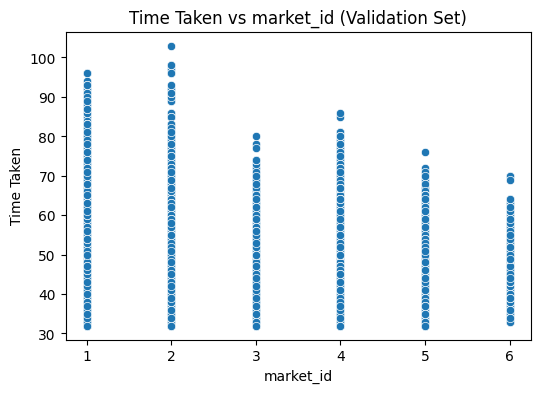

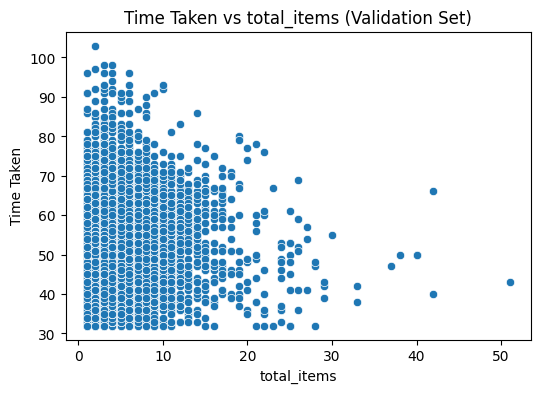

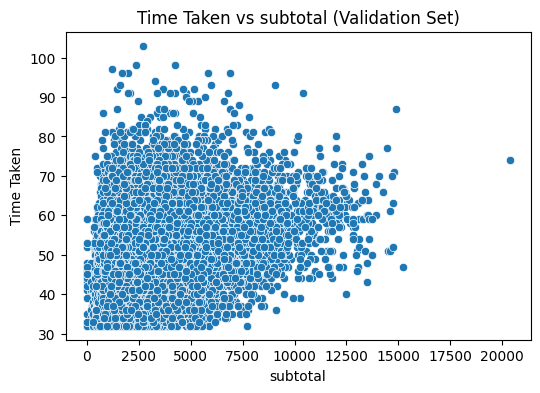

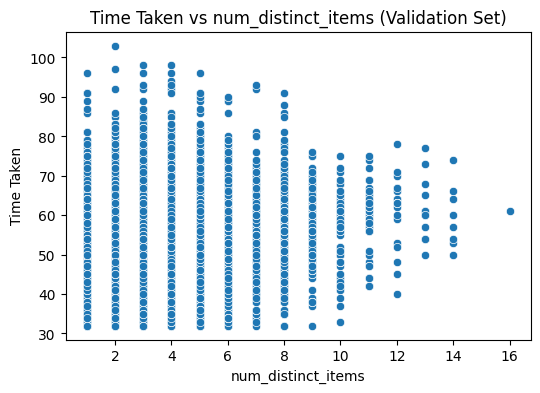

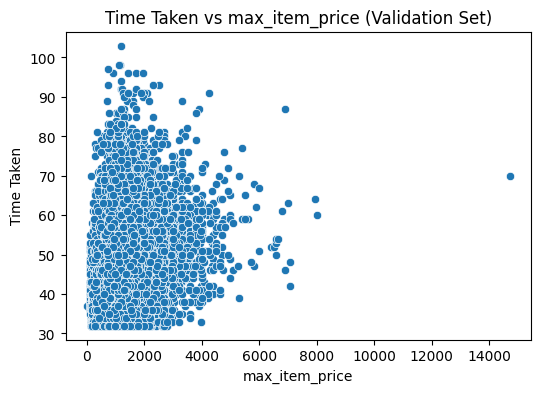

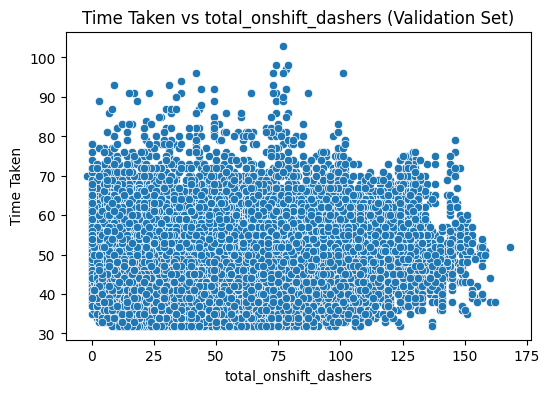

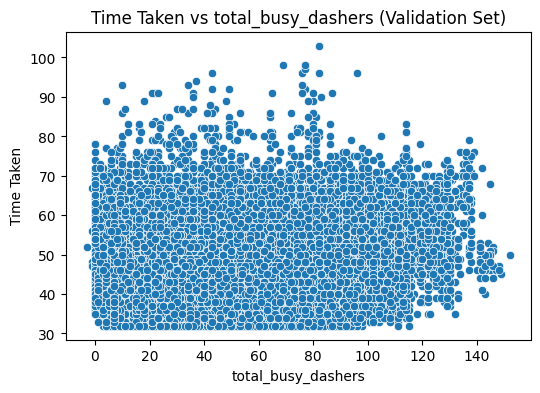

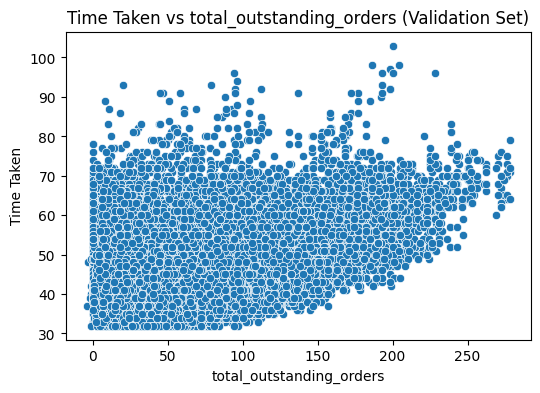

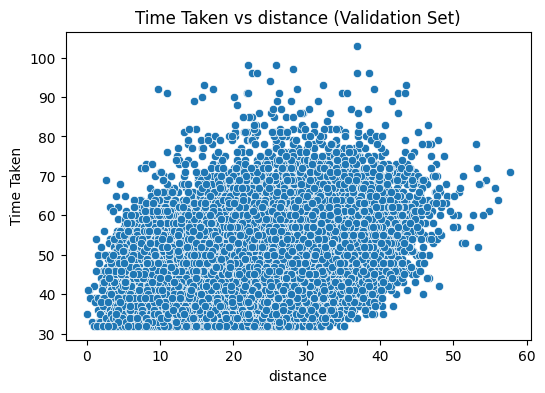

In [25]:
# Scatter plot to visualise the relationship between time_taken and other features
for col in numerical_cols_test:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_test[col], y=y_test)
    plt.title(f'Time Taken vs {col} (Validation Set)')
    plt.xlabel(col)
    plt.ylabel('Time Taken')
    plt.show()



#### **4.3** Drop the columns with weak correlations with the target variable

In [26]:
# Drop the weakly correlated columns from training dataset
# Ensure test set still aligns with training features
X_test = X_test[X_train.columns]



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [ ]:
# Import libraries



#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [27]:
# Apply scaling to the numerical columns

scaler = StandardScaler()

# Fit scaler only on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [29]:
# Create/Initialise the model
lr = LinearRegression()


In [30]:
# Train the model using the training data
# Fit model
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [31]:
# Make predictions
y_pred = lr.predict(X_test_scaled)

In [32]:
# Find results for evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



MAE: 2.31
RMSE: 3.22
R² Score: 0.88


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [34]:
# Loop through the number of features and test the model

rfe = RFE(lr, n_features_to_select=8)
rfe.fit(X_train_scaled, y_train)

# Get mask of selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", list(selected_features))


Selected Features: ['market_id', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'order_protocol_5.0']


In [35]:
# Build the final model with selected number of features
# Subset the data
X_train_rfe = X_train_scaled[:, rfe.support_]
X_test_rfe = X_test_scaled[:, rfe.support_]

# Retrain the model
lr_rfe = LinearRegression()
lr_rfe.fit(X_train_rfe, y_train)

# Predict
y_pred_rfe = lr_rfe.predict(X_test_rfe)

# Evaluation
mae_rfe = mean_absolute_error(y_test, y_pred_rfe)
rmse_rfe = np.sqrt(mean_squared_error(y_test, y_pred_rfe))
r2_rfe = r2_score(y_test, y_pred_rfe)

print("\nModel Performance After RFE:")
print(f"MAE: {mae_rfe:.2f}")
print(f"RMSE: {rmse_rfe:.2f}")
print(f"R² Score: {r2_rfe:.2f}")




Model Performance After RFE:
MAE: 2.49
RMSE: 3.39
R² Score: 0.87


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

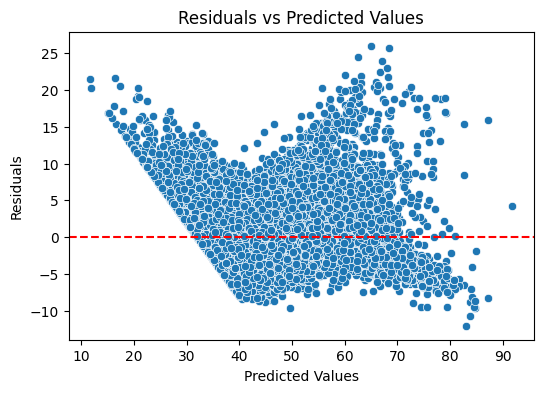

In [36]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
residuals = y_test - y_pred_rfe

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_rfe, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()



[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


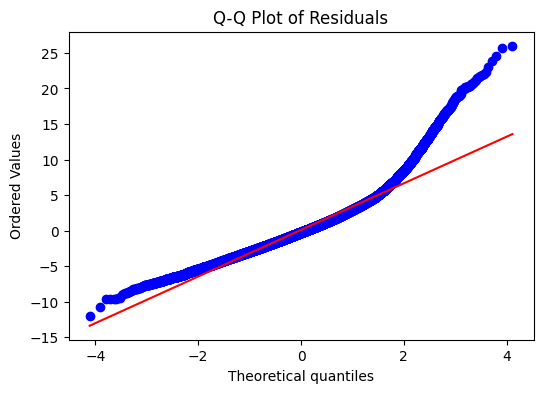

In [37]:
# Compare the scaled vs unscaled features used in the final model
import scipy.stats as stats

plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()



Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

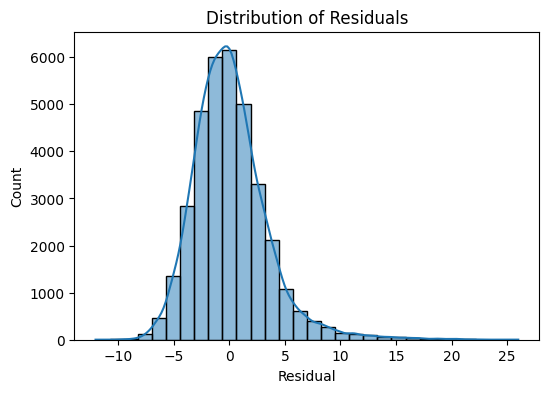

In [38]:
# Analyze the effect of a unit change in a feature, say 'total_items'
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.show()



Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, there are a few categorical columns like store_primary_category, order_protocol, and isWeekend. After converting them into categories and checking their distributions, I noticed that some categories seemed to influence the delivery time. For example, fast food orders or weekends might have different patterns than regular days or dine-in orders. So, I think these features can impact how fast an order gets delivered.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>It means I used 20% of the data as test data and 80% for training. This helps check how well the model performs on data it hasn't seen before.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>The distance column had the strongest positive correlation with delivery time. That makes sense — longer distances usually mean more delivery time.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**
>I used boxplots to look for outliers in the time_taken column and used the IQR method to remove extreme values. This helped make the data more consistent and avoid big errors in the model.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>Based on RFE and the final model, the top 3 features were:

    distance

    total_busy_dashers

    total_items
    These features had the most influence on how long it took for an order to be delivered.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear regression finds the best straight line to predict a target value (like delivery time) using input features. It calculates how each feature affects the result and gives a formula like:
> <code>time = a + b1*feature1 + b2*feature2 + ... </code>
>The model tries to minimize the difference between predicted and actual values by adjusting the coefficients.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple linear regression uses just one input feature to predict the output. Multiple linear regression uses two or more input features. Multiple is more useful when the output depends on many things, like in this case.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function shows how wrong the model's predictions are. In linear regression, we usually use Mean Squared Error. The model tries to reduce this value by adjusting the line (coefficients) using a method like gradient descent.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting happens when the model is too focused on the training data and doesn't work well on new data. Underfitting means the model is too simple and misses important patterns. A good model should be balanced — not too simple and not too complex.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots show the difference between actual and predicted values. If the points are randomly scattered around zero, it means the model is doing well. If there’s a clear pattern, it means the model might be missing something, like non-linearity or outliers.